# Deep Gaussian Process Regression Model

This notebook demonstrates the use of a deep GP model in MXFusion.

In [1]:
import mxfusion
import numpy as np
from mxfusion.common import config
config.DEFAULT_DTYPE = 'float64'

/Users/marpulli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
N = 50 # training size
X = np.linspace(-5, 5, N)[:, None]
Y = (X > 0).astype(float)

# gpflow model

In [3]:
from gpflow.kernels import RBF, White
from gpflow.likelihoods import Gaussian
from doubly_stochastic_dgp.dgp import DGP
def make_gpflow_model(X, Y, Z, L):
    D = X.shape[1]
    # the layer shapes are defined by the kernel dims, so here all hidden layers are D dimensional 
    kernels = []
    for l in range(L):
        kernels.append(RBF(D))

    # between layer noise (doesn't actually make much difference but we include it anyway)
    for kernel in kernels[:-1]:
        kernel += White(D, variance=1e-5) 

    mb = 1000 if X.shape[0] > 1000 else None
    print(X.shape)
    print(Y.shape)
    print(Z.shape)
    model = DGP(X, Y, Z, kernels, Gaussian(), num_samples=200, minibatch_size=mb)
    return model

/Users/marpulli/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


In [4]:
from gpflow.training import AdamOptimizer
dgp = make_gpflow_model(X, Y, np.linspace(-5, 5, 10)[:, None], 2)
AdamOptimizer(0.01).minimize(dgp, maxiter=2000)

(50, 1)
(50, 1)
(10, 1)
1 1


In [5]:
xt = np.linspace(-10, 10,200)[:, None]

dgp_mean_s, v = dgp.predict_f(xt, 500)
dgp_mean = dgp_mean_s.mean(axis=0)[:, 0]
std = np.sqrt(v.mean(axis=0) + dgp_mean_s.var(axis=0))[:, 0]

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(xt, dgp_mean)
plt.fill_between(xt[:, 0], dgp_mean-std, dgp_mean+std, alpha=0.1)
plt.scatter(X, Y)
plt.show()

<Figure size 1200x800 with 1 Axes>

# MXFusion model from gpflow params

In [7]:
import mxnet as mx
import mxfusion.components.distributions.gp.kernels
from mxfusion.components.variables import PositiveTransformation
from mxfusion.modules.gp_modules.dgp import DeepGPRegression


M = 10
m = mxfusion.Model()
m.N = mxfusion.Variable()
m.X = mxfusion.Variable(shape=(m.N, 1))
m.Z_0 = mxfusion.Variable(shape=(M, 1), initial_value=mx.nd.array(np.linspace(-5, 5, 10)[:, None]))
m.Z_1 = mxfusion.Variable(shape=(M, 1), initial_value=mx.nd.array(np.linspace(-5, 5, 10)[:, None]))
m.noise_var = mxfusion.Variable(transformation=PositiveTransformation())
kernels = [mxfusion.distributions.gp.kernels.RBF(1), mxfusion.distributions.gp.kernels.RBF(1)]
m.Y = DeepGPRegression.define_variable(m.X, kernels, m.noise_var, shape=(m.N, 1), inducing_inputs=[m.Z_0, m.Z_1], n_samples=250)

In [8]:
post = m.Y.factor._extra_graphs[0]

In [9]:
from mxfusion.inference import Inference, MAP
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
dtype = 'float64'
infr = Inference(MAP(model=m, observed=[m.X, m.Y]), dtype=dtype)
infr.initialize(X=X.shape, Y=Y.shape)

# inducing locations
infr.params[m.Z_0] = dgp.layers[0].feature.Z.value
infr.params[m.Z_1] = dgp.layers[1].feature.Z.value

/Users/marpulli/git/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


In [10]:
# variational mean
infr.params[post.qU_mean_0] = dgp.layers[0].q_mu.value
infr.params[post.qU_mean_1] = dgp.layers[1].q_mu.value

In [11]:
# variational cov
infr.params[post.qU_cov_W_0] = dgp.layers[0].q_sqrt.value[0, :, :]
infr.params[post.qU_cov_W_1] = dgp.layers[1].q_sqrt.value[0, :, :]

infr.params[post.qU_cov_diag_0] = mx.nd.zeros(10)
infr.params[post.qU_cov_diag_1] = mx.nd.zeros(10)

In [12]:
# likelihood
infr.params[m.noise_var] = mx.nd.array(dgp.likelihood.likelihood.variance.value[None])

In [13]:
# kernels
infr.params[kernels[0].lengthscale] = mx.nd.array(dgp.layers[0].kern.lengthscales.value[None])
infr.params[kernels[1].lengthscale] = mx.nd.array(dgp.layers[1].kern.lengthscales.value[None])

infr.params[kernels[0].variance] = mx.nd.array(dgp.layers[0].kern.variance.value[None])
infr.params[kernels[1].variance] = mx.nd.array(dgp.layers[1].kern.variance.value[None])

In [14]:
m.Y.factor.dgp_log_pdf.verbose = True
loss, _ = infr.run(X=mx.nd.array(X, dtype=dtype), Y=mx.nd.array(Y, dtype=dtype))

/Users/marpulli/git/MXFusion/mxfusion/inference/inference.py:155: UserWarning: Trying to initialize the inference twice, skipping.
  warnings.warn("Trying to initialize the inference twice, skipping.")


/Users/marpulli/git/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


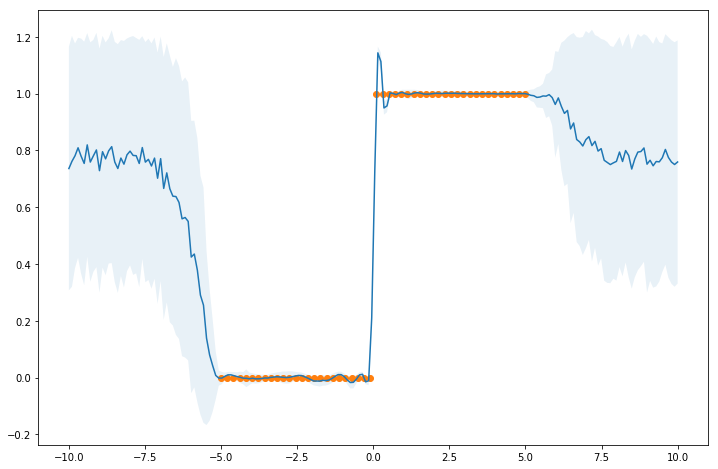

In [15]:
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.X], target_variables=[m.Y]), 
                              infr_params=infr.params)

res = infr_pred.run(X=mx.nd.array(xt, dtype='float64'))[0]
f_mean, f_var = res[0].asnumpy()[0], res[1].asnumpy()[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

mean = res[0].asnumpy()[:, 0]
plt.plot(xt, res[0].asnumpy())

std = np.sqrt(res[1].asnumpy())[:, 0]
plt.fill_between(xt[:, 0], mean - std, mean + std, alpha=0.1)
plt.scatter(X, Y)

# MXFusion model training

In [16]:
import mxnet as mx
import mxfusion.components.distributions.gp.kernels
from mxfusion.components.variables import PositiveTransformation
from mxfusion.modules.gp_modules.dgp import DeepGPRegression

M = 10
m = mxfusion.Model()
m.N = mxfusion.Variable()
m.X = mxfusion.Variable(shape=(m.N, 1))
m.Z_0 = mxfusion.Variable(shape=(M, 1), initial_value=mx.nd.array(np.linspace(-5, 5, 10)[:, None]))
m.Z_1 = mxfusion.Variable(shape=(M, 1), initial_value=mx.nd.array(np.linspace(-5, 5, 10)[:, None]))
m.noise_var = mxfusion.Variable(transformation=PositiveTransformation())
kernels = [mxfusion.distributions.gp.kernels.RBF(1), mxfusion.distributions.gp.kernels.RBF(1)]
m.Y = DeepGPRegression.define_variable(m.X, kernels, m.noise_var, shape=(m.N, 1), inducing_inputs=[m.Z_0, m.Z_1], n_samples=250)

In [25]:
import mxnet as mx
from mxfusion.inference import GradBasedInference, MAP

infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]))
infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'), 
         max_iter=2000, learning_rate=0.05, verbose=True)

/Users/marpulli/git/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


Iteration 201 loss: 1.68053752282795863
Iteration 401 loss: 138.794463367614535
Iteration 601 loss: -30.5388192880284582
Iteration 801 loss: -44.669072171887345
Iteration 1001 loss: -45.740896761827464
Iteration 1201 loss: -33.6625744858766966
Iteration 1401 loss: -46.594568103290015
Iteration 1601 loss: 16.4018756334562575
Iteration 1801 loss: -20.1285943628223872
Iteration 2000 loss: -26.848650710328658

/Users/marpulli/git/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


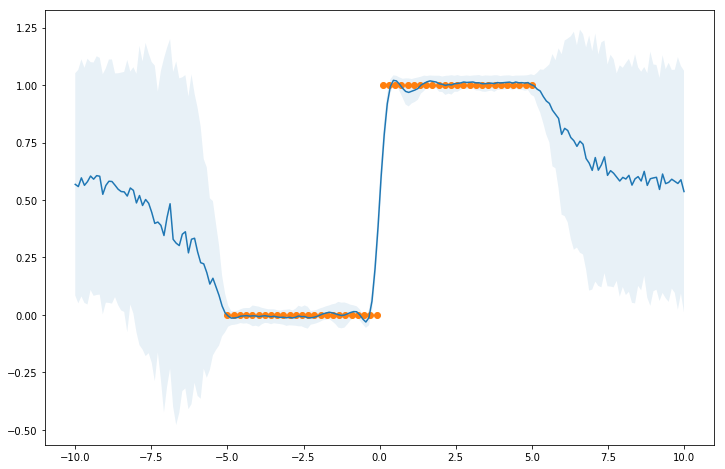

In [26]:
infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.X], target_variables=[m.Y]), 
                              infr_params=infr.params)

res = infr_pred.run(X=mx.nd.array(xt, dtype='float64'))[0]
f_mean, f_var = res[0].asnumpy()[0], res[1].asnumpy()[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

mean = res[0].asnumpy()[:, 0]
plt.plot(xt, res[0].asnumpy())

std = np.sqrt(res[1].asnumpy())[:, 0]
plt.fill_between(xt[:, 0], mean - std, mean + std, alpha=0.1)
plt.scatter(X, Y)